## Investigating the Impact of Residual Connection to Convolutional Layer on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of residual connection with convolutional layers on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %mkdir /content/drive/MyDrive/ED_Experiments
# %mkdir /content/drive/MyDrive/ED_Experiments/ED_CNN_E13

In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_CNN_E13
%ls

/content/drive/MyDrive/ED_Experiments/ED_CNN_E13
'model_fold_1 (1).log'               model_fold_3.log
 model_fold_1.h5                     model_fold_3_loss_accuracy.png
 model_fold_1.log                    model_fold_3.png
 model_fold_1_loss_accuracy.png      model_fold_3_precision_recall.png
 model_fold_1.png                    model_fold_4.h5
 model_fold_1_precision_recall.png   model_fold_4.log
 model_fold_2.h5                     model_fold_4_loss_accuracy.png
 model_fold_2.log                    model_fold_4.png
 model_fold_2_loss_accuracy.png      model_fold_4_precision_recall.png
 model_fold_2.png                    model_fold_5.h5
 model_fold_2_precision_recall.png   model_fold_5.log
 model_fold_3.h5                     model_fold_5.png


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  \
0      X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   
1      X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   
2         X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57   
3       X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   
4       X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
11495  X22.V1.114  -22  -22  -23  -26  -36  -42  -45  -42  -45  ...    15   
11496  X19.V1.354  -47  -11   28   77  141  211  246  240  193  ...   -65   
11497    X8.V1.28   14    6  -13  -16   10   26   27   -9    4  ...   -65   
11498  X10.V1.932  -40  -25   -9  -12   -2   12    7   19   22  ...   121   
11499  X16.V1.210   29   41   57   72   74   62   54   43   31  ...   -59   

       X171  X172  X173  X174  X175  X176  X177  X178  y  
0       -15   -31   -77  -103  -127  -116   -83   -51  4  
1       150   146   152   157   156   154   143   129  1  
2        64    48    19   -12   -30   -35   -35   -36  5  
3       -81   -80   -77   -85   -77   -72   -69   -65  5  
4         2   -12   -32   -41   -65   -83   -89   -73  5  
...     ...   ...   ...   ...   ...   ...   ...   ... ..  
11495    16    12     5    -1   -18   -37   -47   -48  2  
11496   -33    -7    14    27    48    77   117   170  1  
11497   -48   -61   -62   -67   -30    -2    -1    -8  5  
11498   135   148   143   116    86    68    59    55  3  
11499   -25    -4     2     5     4    -2     2    20  4  

[11500 rows x 180 columns]

In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

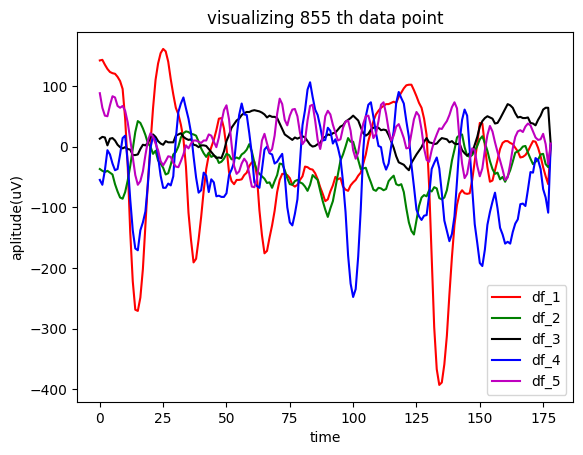

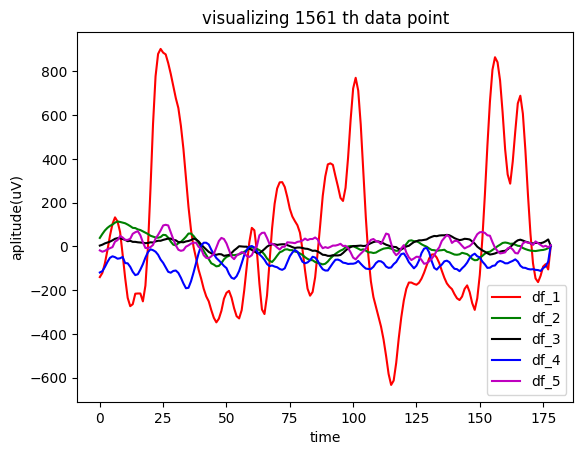

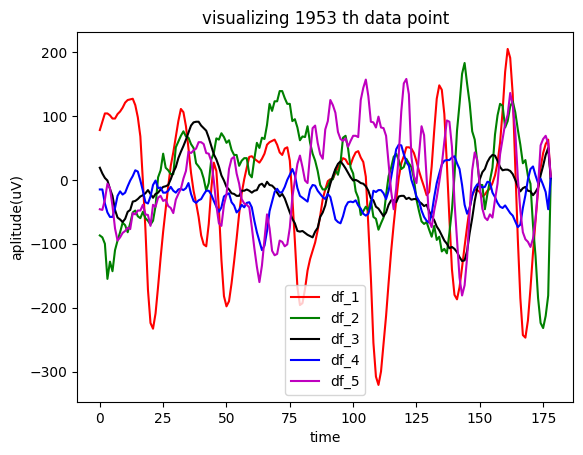

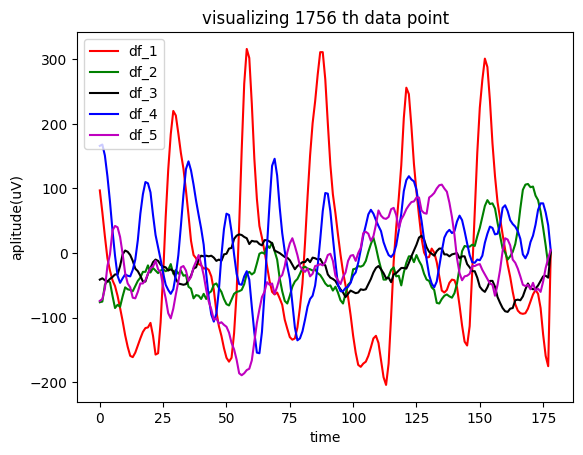

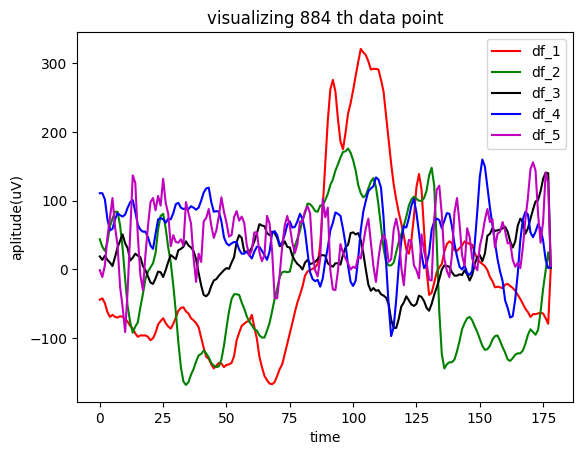

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '_loss_accuracy.png')

    plt.show()

In [ ]:
def plot_precision_recall(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['precision'], 'b-')
    ax[0].plot(history.history['val_precision'], 'r-')
    ax[0].legend(['train_precision', 'val_precision'])
    ax[0].set_title('precision curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Precision %')

    ax[1].plot(history.history['recall'], 'b-')
    ax[1].plot(history.history['val_recall'], 'r-')
    ax[1].legend(['train_recall', 'val_recall'])
    ax[1].set_title('recall curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Recall %')

    plt.suptitle(title)
    plt.savefig(title + '_precision_recall.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the Residual Connection



In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape):
#         super(eegClassifier, self).__init__()

#         self.conv_layers = 5

#         self.conv1 = layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')
#         self.bn1 = layers.BatchNormalization()
#         self.max_pool1 = layers.MaxPooling1D(2, padding='same')

#         self.conv2 = layers.Conv1D(filters=256, kernel_size=3, padding='valid', activation='relu')
#         self.bn2 = layers.BatchNormalization()
#         self.max_pool2 = layers.MaxPooling1D(2, padding='same')

#         self.conv3 = layers.Conv1D(filters=512, kernel_size=3, padding='valid', activation='relu')
#         self.bn3 = layers.BatchNormalization()
#         self.max_pool3 = layers.MaxPooling1D(2, padding='same')

#         self.conv4 = layers.Conv1D(filters=1024, kernel_size=3, padding='valid', activation='relu')
#         self.bn4 = layers.BatchNormalization()
#         self.max_pool4 = layers.MaxPooling1D(2, padding='same')

#         self.conv5 = layers.Conv1D(filters=2048, kernel_size=3, padding='valid', activation='relu')
#         self.bn5 = layers.BatchNormalization()
#         self.max_pool5 = layers.MaxPooling1D(2, padding='same')

#         self.flatten = layers.Flatten()

#         self.dense_1 = layers.Dense(128, activation='relu')
#         self.dense_2 = layers.Dense(32, activation='relu')

#         self.output_dense = layers.Dense(1, activation='sigmoid')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.max_pool1(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.max_pool2(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.max_pool3(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.max_pool4(x)

#         x = self.conv5(x)
#         x = self.bn5(x)
#         x = self.max_pool5(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = self.dense_2(x)

#         return self.output_dense(x)


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# def residual_block(x, filters, kernel_size, padding='same', activation='relu'):
#     shortcut = x
#     x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(activation)(x)
#     x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Add()([shortcut, x])
#     x = layers.Activation(activation)(x)
#     return x

# def create_residual_eeg_model(input_shape):
#     inputs = keras.Input(shape=input_shape)
#     x = layers.Conv1D(filters=128, kernel_size=5, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=128, kernel_size=5)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=256, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=256, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=512, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=512, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=1024, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=1024, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=2048, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=2048, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dense(32, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model


In [ ]:


def residual_block(x, filters, kernel_size, padding='same', activation='relu'):
    shortcut = x
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation(activation)(x)
    return x

def create_residual_eeg_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=128, kernel_size=5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=128, kernel_size=5)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=1024, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=2048, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=2048, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.GlobalAveragePooling1D()(x)  # Replace Flatten layer with GlobalAveragePooling1D
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)

In [ ]:
X_train.shape

(9200, 178, 1)

In [ ]:
from tensorflow import keras
import numpy as np

# Load your model
model = keras.models.load_model('/content/drive/MyDrive/seizureVsAll/model_fold_3.h5')




In [ ]:
data_point = X_val[1, :, :]
data_point = data_point.reshape(1, -1, 1)

In [ ]:
model(data_point)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6258576e-24]], dtype=float32)>

In [ ]:
y_val[1]

0

In [ ]:
# Assuming `data_point` is your new data point, with shape (1, input_shape)
data_point = X_train[1, :, :]
data_point = data_point.reshape(1, -1, 1)

# Get the outputs of each layer
outputs = [layer.output for layer in model.layers]

# Create a list to store the output after each layer
output_values = []

# For each output, create a new function that you can call to get the output for a data point
for output in outputs:
    functor = keras.backend.function([model.input], [output])
    output_values.append(functor([data_point]))

# for i, output_value in enumerate(output_values):
#     print(f"Output after layer {i+1} is {output_value[0].shape}")

In [ ]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

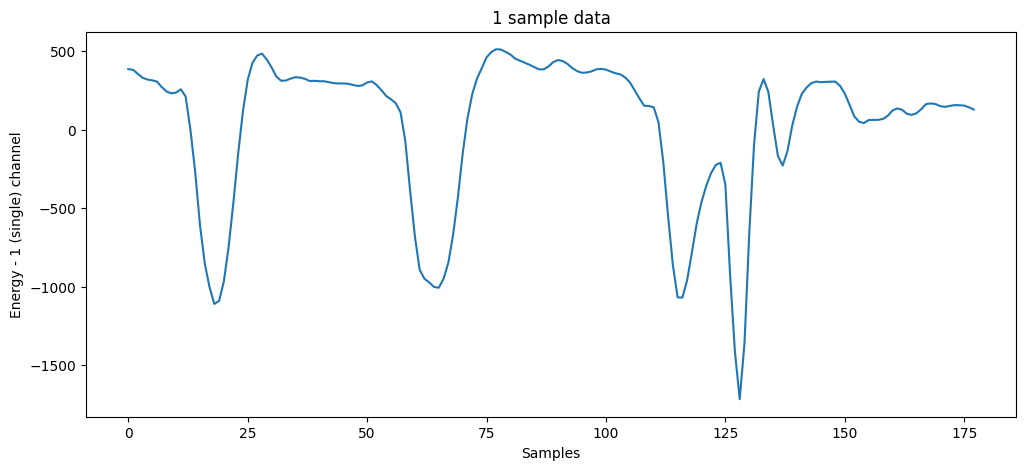

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(X_train[0, :, :])
plt.xlabel('Samples')
plt.ylabel('Energy - 1 (single) channel')
plt.title('1 sample data')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # As before, load the model and get the outputs for the datapoint

# # ...

# # Identify Conv1D layers within the residual blocks
# conv1_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv1D)]

# # For each Conv1D layer, create a new function to get its output
# conv_outputs = []
# for layer in conv1_layers:
#     functor = keras.backend.function([model.input], [layer.output])
#     conv_outputs.append(functor([data_point]))

# # Plot the outputs of each Conv1D layer
# resnets = [3, 6, 9, 12, 15]
# for i, conv_output in enumerate(conv_outputs):
#     if i+1 in resnets:
#         print(conv_output[0].shape)
#         print(len(conv_output))
#         plt.figure(figsize=(10, 3))
#         for j in range(conv_output[0].shape[-1]):
#             plt.plot(conv_output[0][0, :, j])  # plot the first filter output
#         plt.title(f'Output after Conv1D Layer {i+1}')
#         plt.show()


[<keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7a14433df310>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7a144334e620>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7a144335d4e0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7a144335ffa0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7a144336f220>]
5
(1, 89, 128)
1


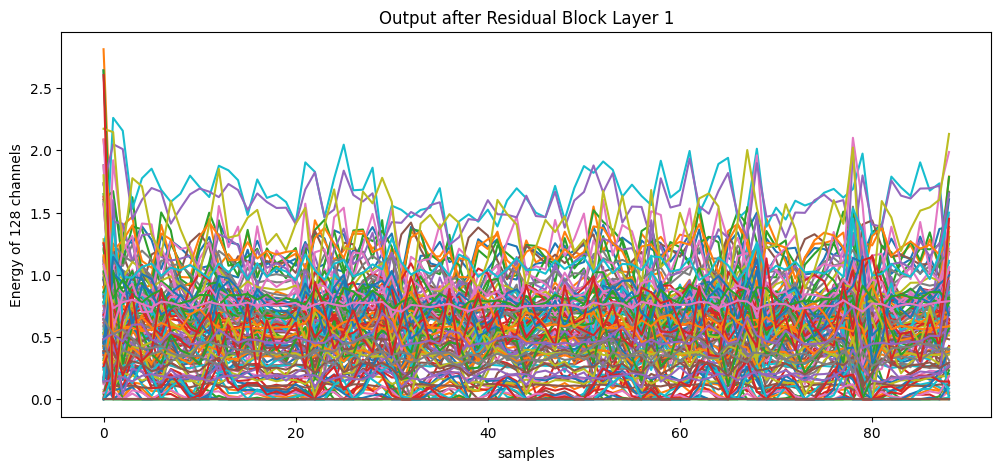

(1, 45, 256)
1


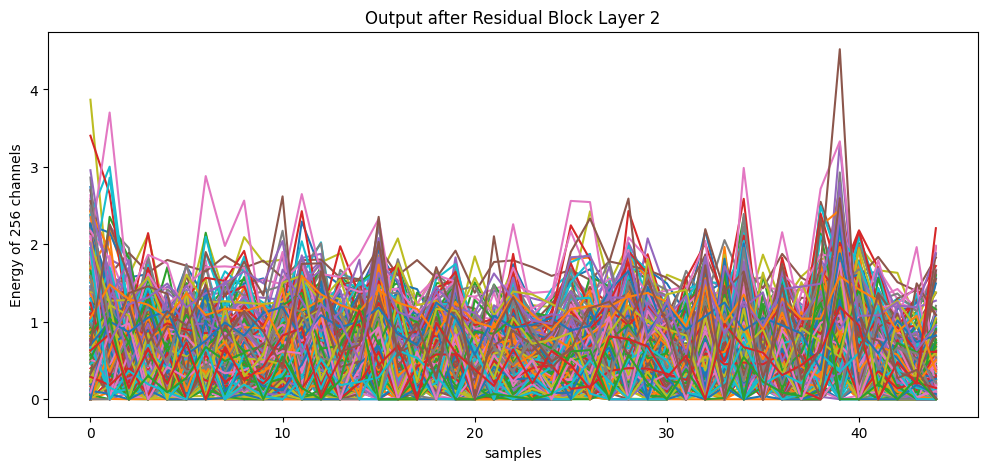

(1, 23, 512)
1


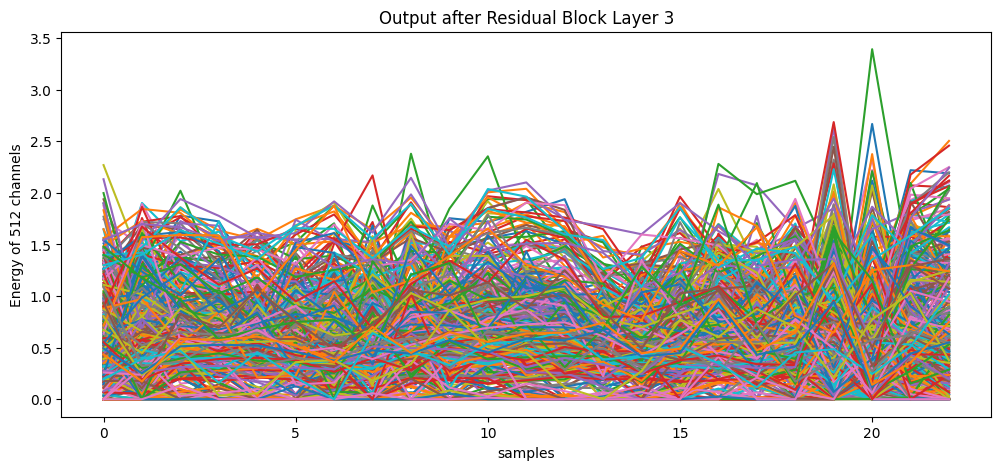

(1, 12, 1024)
1


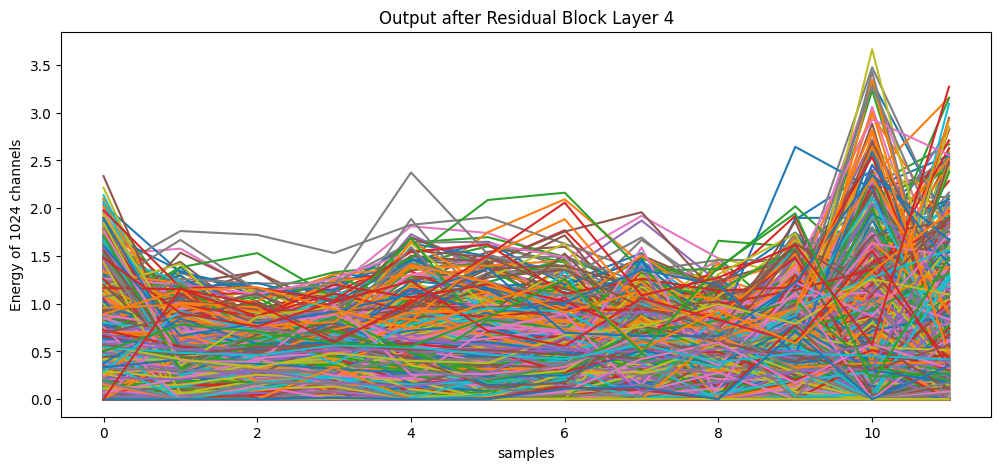

(1, 6, 2048)
1


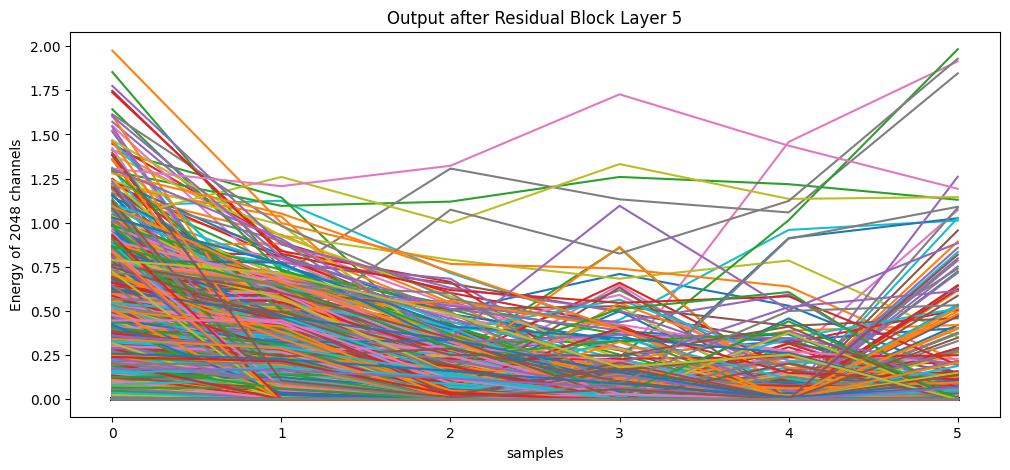

In [ ]:
import matplotlib.pyplot as plt

# As before, load the model and get the outputs for the datapoint

# ...

# Identify Conv1D layers within the residual blocks
maxpool_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.MaxPooling1D)]
print(maxpool_layers)
# For each Conv1D layer, create a new function to get its output
maxpool_outputs = []
for layer in maxpool_layers:
    functor = keras.backend.function([model.input], [layer.output])
    maxpool_outputs.append(functor([data_point]))
print(len(maxpool_outputs))
# Plot the outputs of each Conv1D layer
resnets = [3, 6, 9, 12, 15]
for i, maxpool_output in enumerate(maxpool_outputs):
    print(maxpool_output[0].shape)
    print(len(maxpool_output))
    plt.figure(figsize=(12, 5))
    for j in range(maxpool_output[0].shape[-1]):
        plt.plot(maxpool_output[0][0, :, j])  # plot the first filter output
    plt.title(f'Output after Residual Block Layer {i+1}')
    plt.xlabel('samples')
    plt.ylabel(f'Energy of {maxpool_output[0].shape[-1]} channels')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# As before, load the model and get the outputs for the datapoint

# ...

# Identify Conv1D layers within the residual blocks
maxpool_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Dense)]
print(maxpool_layers)
# For each Conv1D layer, create a new function to get its output
maxpool_outputs = []
for layer in maxpool_layers:
    functor = keras.backend.function([model.input], [layer.output])
    maxpool_outputs.append(functor([data_point]))
print(len(maxpool_outputs))
# Plot the outputs of each Conv1D layer



[<keras.layers.core.dense.Dense object at 0x7a144336fa30>, <keras.layers.core.dense.Dense object at 0x7a144336fbe0>, <keras.layers.core.dense.Dense object at 0x7a144336ffa0>]
3


In [ ]:
maxpool_outputs[0][0].shape

(1, 128)

(1, 128)
1
(1, 128)


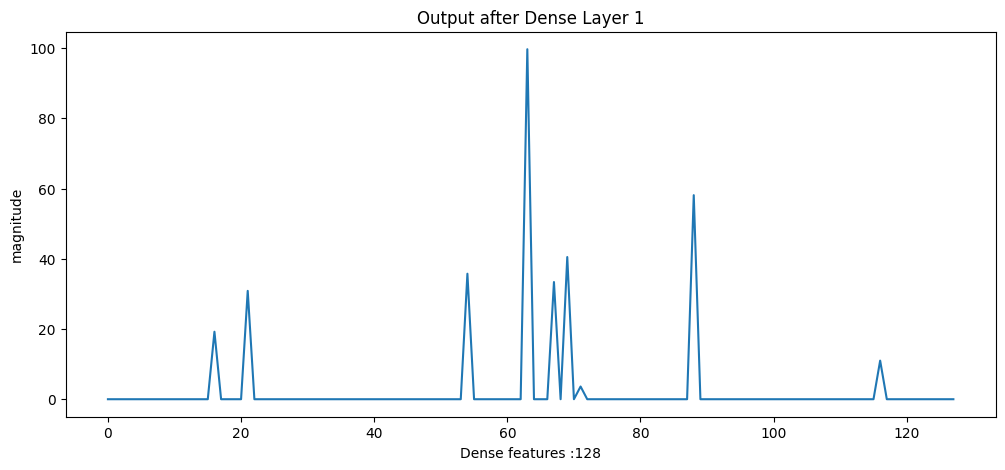

(1, 32)
1
(1, 32)


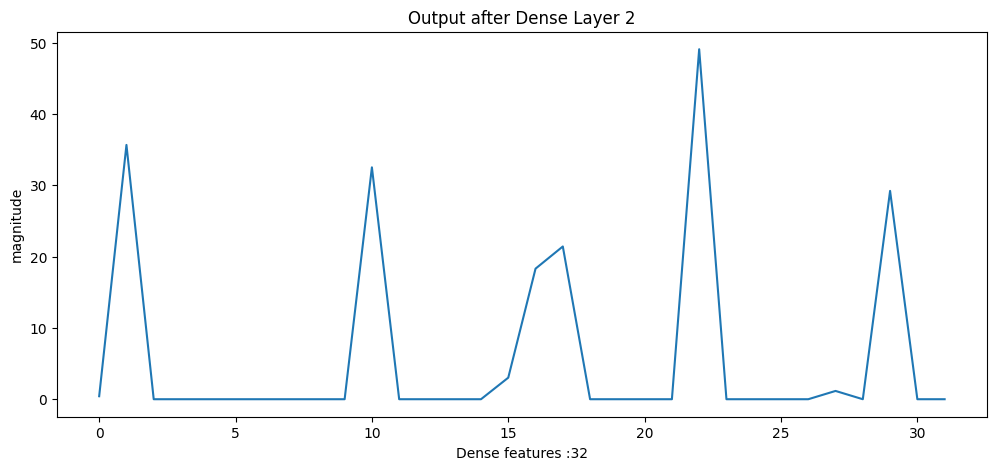

(1, 1)
1
(1, 1)


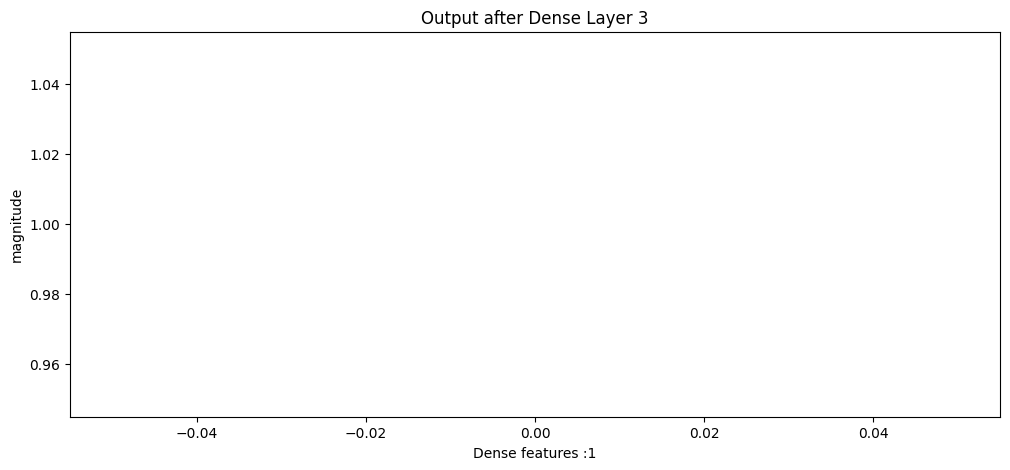

In [ ]:
for i, maxpool_output in enumerate(maxpool_outputs):
    print(maxpool_output[0].shape)
    print(len(maxpool_output))
    print(maxpool_output[0].shape)
    plt.figure(figsize=(12, 5))
    # for j in range(maxpool_output[0].shape[-1]):
    plt.plot(maxpool_output[0].T)  # plot the first filter output
    plt.title(f'Output after Dense Layer {i+1}')
    plt.ylabel('magnitude')
    plt.xlabel(f'Dense features :{maxpool_output[0].shape[-1]}')
    plt.show()



---- fold = 1 ------

Epoch 1/100
288/288 [==============================] - 70s 139ms/step - loss: 0.1494 - accuracy: 0.9486 - precision: 0.8766 - recall: 0.8647 - val_loss: 0.1003 - val_accuracy: 0.9635 - val_precision: 0.8561 - val_recall: 0.9826
Epoch 2/100
288/288 [==============================] - 35s 122ms/step - loss: 0.0938 - accuracy: 0.9668 - precision: 0.9196 - recall: 0.9141 - val_loss: 0.0781 - val_accuracy: 0.9761 - val_precision: 0.9210 - val_recall: 0.9630
Epoch 3/100
288/288 [==============================] - 36s 124ms/step - loss: 0.0777 - accuracy: 0.9710 - precision: 0.9300 - recall: 0.9245 - val_loss: 0.0790 - val_accuracy: 0.9852 - val_precision: 0.9630 - val_recall: 0.9630
Epoch 4/100
288/288 [==============================] - 25s 87ms/step - loss: 0.0688 - accuracy: 0.9746 - precision: 0.9364 - recall: 0.9364 - val_loss: 0.0630 - val_accuracy: 0.9822 - val_precision: 0.9411 - val_recall: 0.9717
Epoch 5/100
288/288 [==============================] - 26s 89ms/s

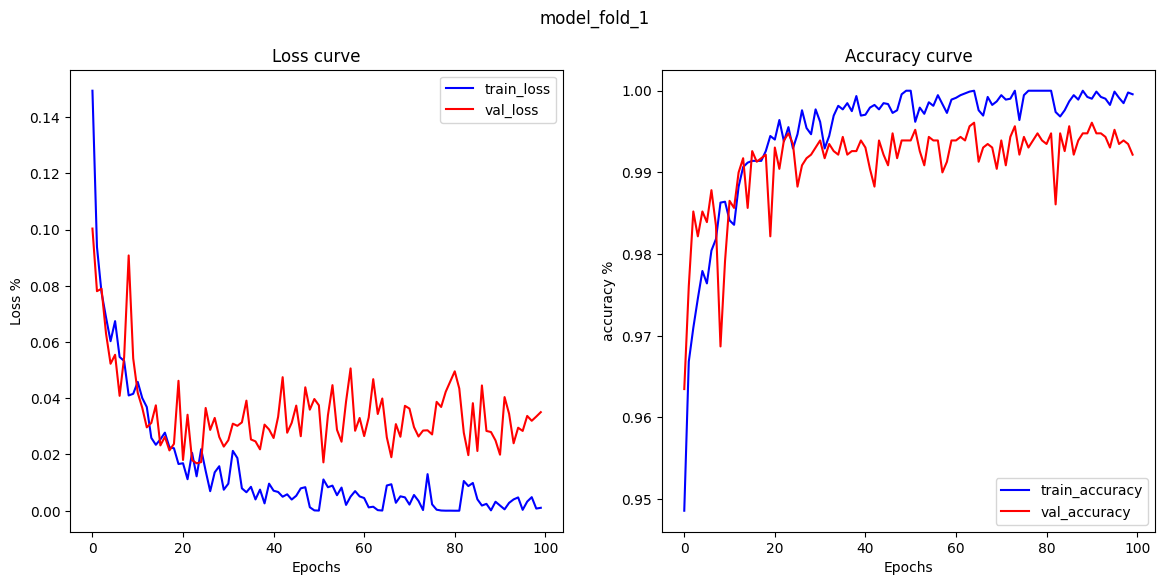

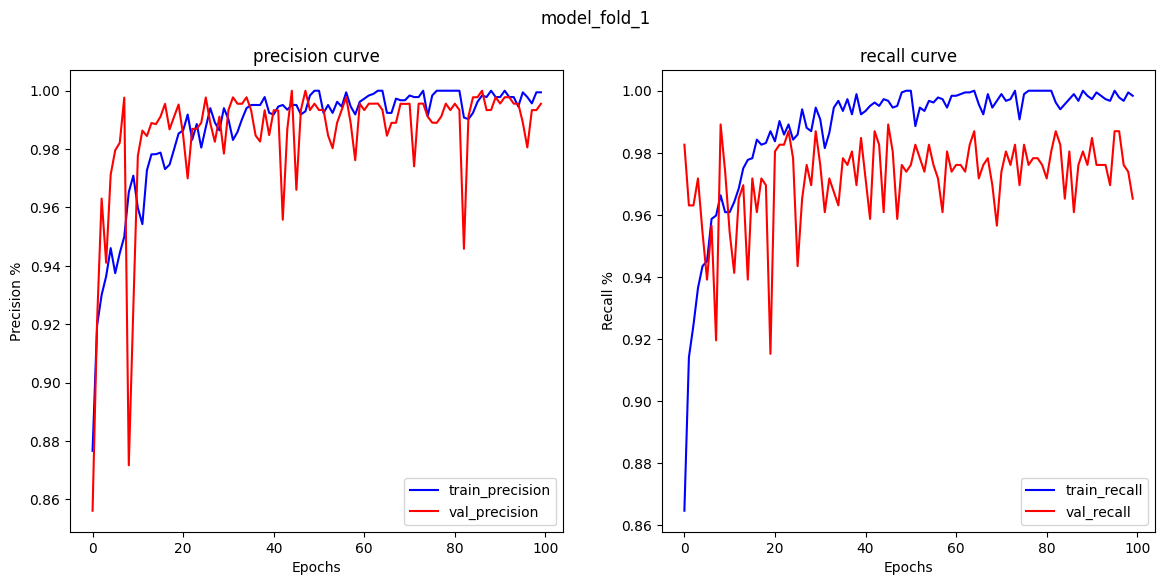



---- fold = 2 ------

Epoch 1/100
288/288 [==============================] - 54s 127ms/step - loss: 0.1451 - accuracy: 0.9490 - precision: 0.8789 - recall: 0.8641 - val_loss: 0.2092 - val_accuracy: 0.9204 - val_precision: 0.7174 - val_recall: 0.9935
Epoch 2/100
288/288 [==============================] - 34s 118ms/step - loss: 0.0904 - accuracy: 0.9664 - precision: 0.9232 - recall: 0.9076 - val_loss: 0.0507 - val_accuracy: 0.9861 - val_precision: 0.9573 - val_recall: 0.9739
Epoch 3/100
288/288 [==============================] - 25s 88ms/step - loss: 0.0724 - accuracy: 0.9746 - precision: 0.9407 - recall: 0.9315 - val_loss: 0.0756 - val_accuracy: 0.9796 - val_precision: 0.9240 - val_recall: 0.9783
Epoch 4/100
288/288 [==============================] - 25s 87ms/step - loss: 0.0622 - accuracy: 0.9790 - precision: 0.9507 - recall: 0.9440 - val_loss: 0.0431 - val_accuracy: 0.9843 - val_precision: 0.9818 - val_recall: 0.9391
Epoch 5/100
288/288 [==============================] - 36s 124ms/s

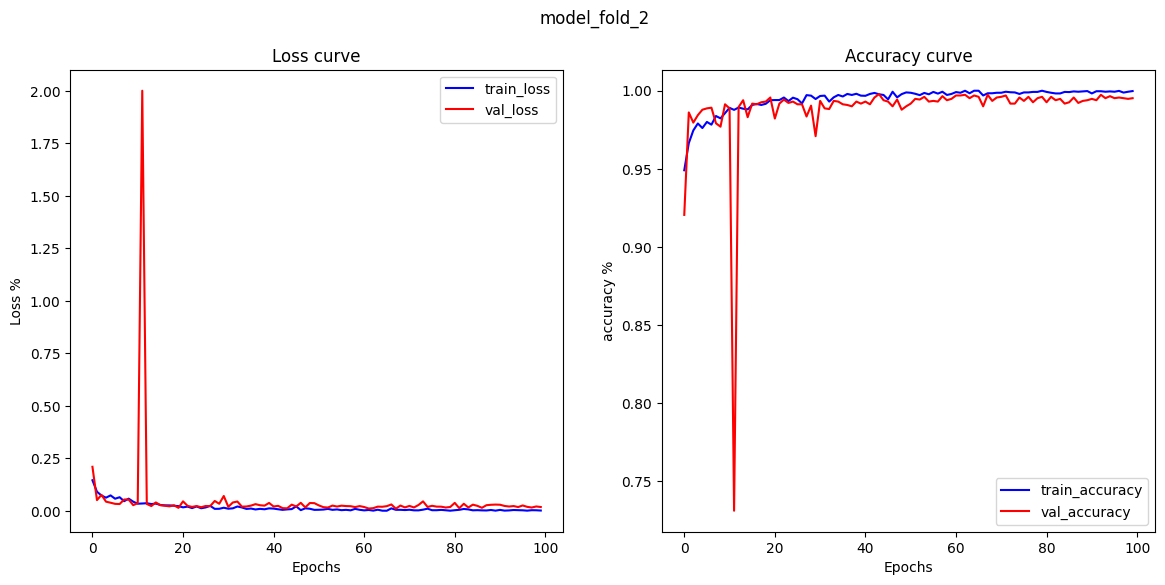

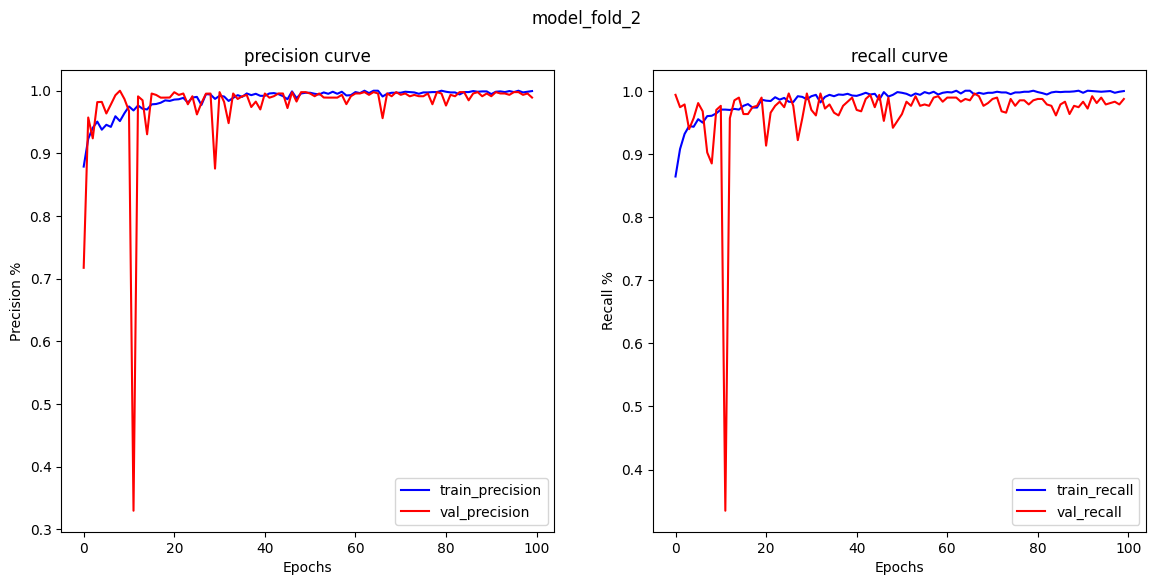



---- fold = 3 ------

Epoch 1/100
288/288 [==============================] - 59s 146ms/step - loss: 0.1502 - accuracy: 0.9510 - precision: 0.8948 - recall: 0.8554 - val_loss: 0.6838 - val_accuracy: 0.9165 - val_precision: 0.7100 - val_recall: 0.9848
Epoch 2/100
288/288 [==============================] - 38s 131ms/step - loss: 0.0941 - accuracy: 0.9658 - precision: 0.9262 - recall: 0.9005 - val_loss: 0.0567 - val_accuracy: 0.9809 - val_precision: 0.9793 - val_recall: 0.9239
Epoch 3/100
288/288 [==============================] - 37s 128ms/step - loss: 0.0739 - accuracy: 0.9752 - precision: 0.9429 - recall: 0.9326 - val_loss: 0.0487 - val_accuracy: 0.9865 - val_precision: 0.9535 - val_recall: 0.9804
Epoch 4/100
288/288 [==============================] - 32s 112ms/step - loss: 0.0602 - accuracy: 0.9797 - precision: 0.9539 - recall: 0.9440 - val_loss: 0.0522 - val_accuracy: 0.9887 - val_precision: 0.9617 - val_recall: 0.9826
Epoch 5/100
288/288 [==============================] - 27s 93ms/

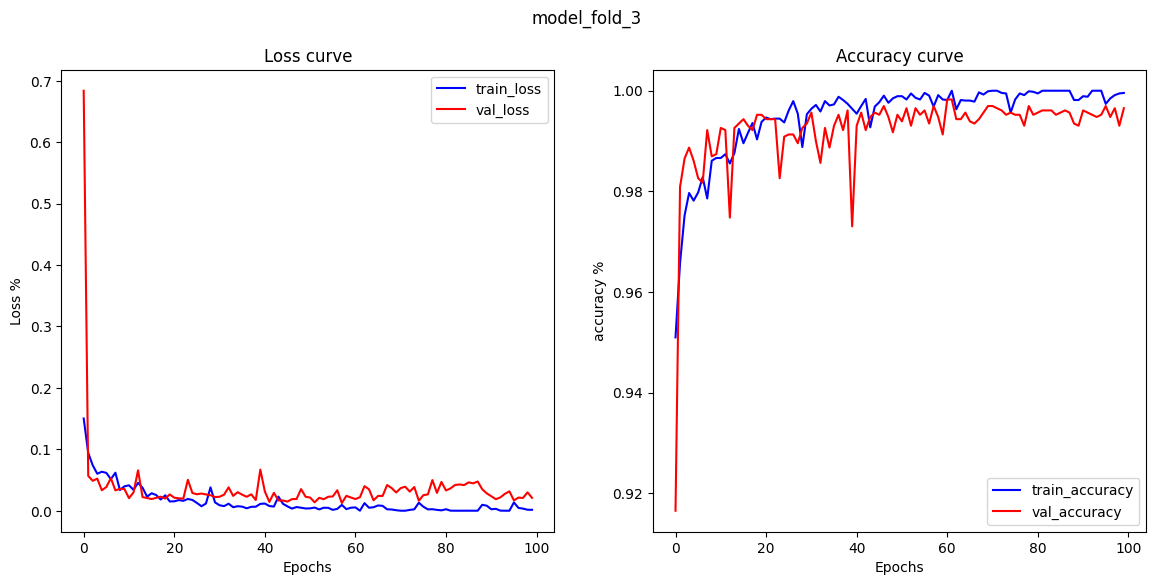

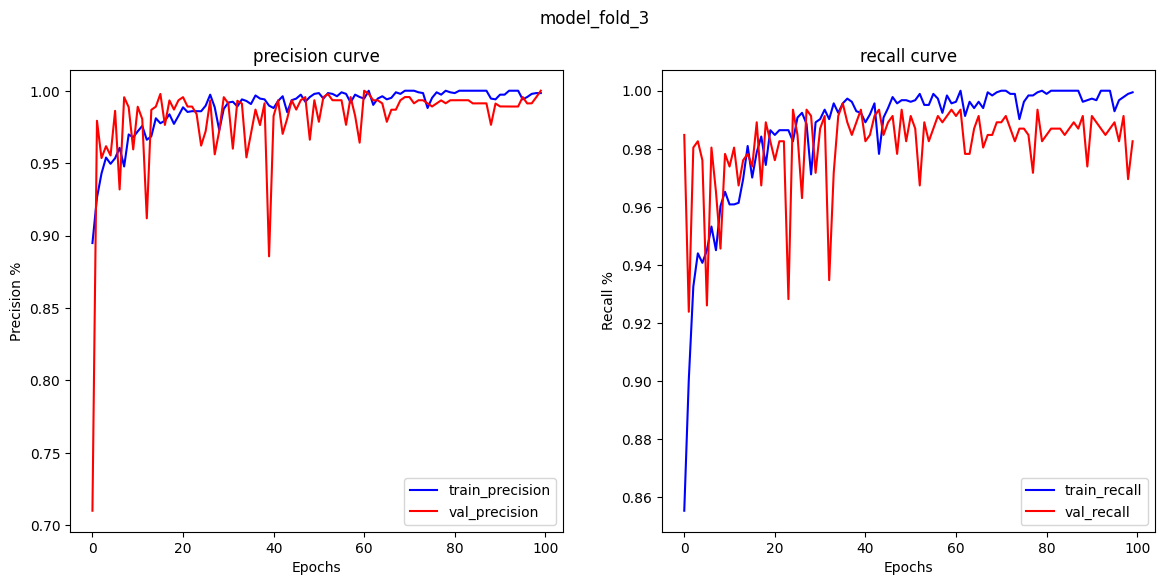



---- fold = 4 ------

Epoch 1/100
288/288 [==============================] - 48s 110ms/step - loss: 0.1421 - accuracy: 0.9496 - precision: 0.8865 - recall: 0.8576 - val_loss: 1.2206 - val_accuracy: 0.7439 - val_precision: 0.4384 - val_recall: 0.9978
Epoch 2/100
288/288 [==============================] - 43s 149ms/step - loss: 0.0994 - accuracy: 0.9649 - precision: 0.9184 - recall: 0.9049 - val_loss: 0.0765 - val_accuracy: 0.9739 - val_precision: 0.9673 - val_recall: 0.9000
Epoch 3/100
288/288 [==============================] - 35s 122ms/step - loss: 0.0812 - accuracy: 0.9713 - precision: 0.9287 - recall: 0.9277 - val_loss: 0.0581 - val_accuracy: 0.9783 - val_precision: 0.9437 - val_recall: 0.9478
Epoch 4/100
288/288 [==============================] - 37s 128ms/step - loss: 0.0710 - accuracy: 0.9775 - precision: 0.9445 - recall: 0.9429 - val_loss: 0.0566 - val_accuracy: 0.9817 - val_precision: 0.9563 - val_recall: 0.9522
Epoch 5/100
288/288 [==============================] - 36s 125ms

In [ ]:

# Perform cross-validation
fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1score = []
fold = 1

for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


    # model = eegClassifier(input_shape)
    model = create_residual_eeg_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                         tf.keras.metrics.Precision(name='precision'),
                                                                         tf.keras.metrics.Recall(name='recall')])
    log_file = f"model_fold_{fold}.log"
    model_name = f"model_fold_{fold}.h5"

    # Clear existing log handlers and close log files
    root_logger = logging.getLogger()
    for handler in root_logger.handlers:
        handler.close()
    root_logger.handlers.clear()

    # Create a separate log file for each model
    logger = init_logger(log_file, stdout=False)


    logger.info(f"\n\n---- fold = {fold} -------\n")
    print(f"\n\n---- fold = {fold} ------\n")

    # Define the checkpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

    # Train the model and capture the history
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                        callbacks=[checkpoint])

    # Log loss and accuracy
    for i, (loss, accuracy, precision, recall) in enumerate(zip(history.history['loss'],
                                                                history.history['accuracy'],
                                                                history.history['precision'],
                                                                history.history['recall'])):
        logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall}")

    for i, (val_loss, val_accuracy, val_precision, val_recall) in enumerate(zip(history.history['val_loss'],
                                                                                history.history['val_accuracy'],
                                                                                history.history['val_precision'],
                                                                                history.history['val_recall'])):
        logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


    # Evaluate the model
    best_model_path = model_name
    best_model = tf.keras.models.load_model(best_model_path)
    loss_scale_optimizer, accuracy, precision, recall = best_model.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)
    fold_precision.append(precision)
    fold_recall.append(recall)

    # Log fold accuracy
    logger.info(f"model_Fold = {fold} accuracy: {accuracy}")
    logger.info(f"model_Fold = {fold} precision: {precision}")
    logger.info(f"model_Fold = {fold} recall: {recall}")


    print(f"model_Fold = {fold} accuracy: {accuracy}")
    print(f"model_Fold = {fold} precision: {precision}")
    print(f"model_Fold = {fold} recall: {recall}")
    print(f"model_Fold = {fold} f1_score: {2*(precision*recall) / (precision + recall)}")

    plot_loss_accuracy(history, f"model_fold_{fold}")
    plot_precision_recall(history, f"model_fold_{fold}")
    # plot_accuracy(history)

    fold += 1

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(fold_accuracy)
mean_precision = np.mean(fold_precision)
mean_recall = np.mean(fold_recall)
mean_f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)

print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1_Score:", mean_f1_score)